In [ ]:
import os
import glob
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights

import albumentations as A
from albumentations.pytorch import ToTensorV2

from torch.utils.tensorboard import SummaryWriter

# -----------------------------
# 1. Mount Google Drive
# -----------------------------
from google.colab import drive
drive.mount('/content/drive')

# -----------------------------
# 2. Đặt đường dẫn tới 4 folder
# -----------------------------
BASE           = '/content/drive/MyDrive'
TRAIN_IMG_DIR  = os.path.join(BASE, 'Training_Data')
TRAIN_MASK_DIR = os.path.join(BASE, 'Training_GroundTruth')
VAL_IMG_DIR    = os.path.join(BASE, 'Test_Data')
VAL_MASK_DIR   = os.path.join(BASE, 'Test_GroundTruth')

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.7'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Mounted at /content/drive


In [ ]:
# -----------------------------
# 3. Dataset & Transforms
# -----------------------------
class ISICDataset(Dataset):
    def __init__(self, pairs, transforms=None):
        self.pairs = pairs
        self.transforms = transforms

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_path, mask_path = self.pairs[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = (mask > 127).astype('float32')
        if self.transforms:
            aug = self.transforms(image=img, mask=mask)
            img, mask = aug['image'], aug['mask']
        return img, mask.unsqueeze(0)

def make_pairs(img_dir, mask_dir):
    if not os.path.exists(img_dir):
        raise ValueError(f"Directory not found: {img_dir}")
    if not os.path.exists(mask_dir):
        raise ValueError(f"Directory not found: {mask_dir}")
    img_paths = sorted(glob.glob(os.path.join(img_dir, '*')))
    mask_paths = sorted(glob.glob(os.path.join(mask_dir, '*')))
    if len(img_paths) != len(mask_paths):
        raise ValueError("Image and mask count mismatch.")
    print(f"Paired {len(img_paths)} samples")
    return list(zip(img_paths, mask_paths))

train_transforms = A.Compose([
    A.Resize(512, 512),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.Affine(translate_percent={'x':(-0.05,0.05),'y':(-0.05,0.05)}, scale=(0.95,1.05), rotate=0, p=0.5),
    A.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
    ToTensorV2(),
])
val_transforms = A.Compose([
    A.Resize(512, 512),
    A.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
    ToTensorV2(),
])

train_ds = ISICDataset(make_pairs(TRAIN_IMG_DIR, TRAIN_MASK_DIR), transforms=train_transforms)
val_ds   = ISICDataset(make_pairs(VAL_IMG_DIR,   VAL_MASK_DIR),   transforms=val_transforms)

print("Train samples:", len(train_ds))
print("Val samples:  ", len(val_ds))

BATCH_SIZE = 4
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=1,           shuffle=False, num_workers=2)

# -----------------------------
# 4. Model, Loss, Optimizer
# -----------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = deeplabv3_resnet50(weights=DeepLabV3_ResNet50_Weights.DEFAULT)
model.classifier[-1]     = nn.Conv2d(256, 1, kernel_size=1)
model.aux_classifier[-1] = nn.Conv2d(256, 1, kernel_size=1)
model = model.to(device)

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
    def forward(self, inputs, targets):
        bce = nn.BCEWithLogitsLoss(reduction='none')(inputs, targets)
        pt  = torch.exp(-bce)
        return (self.alpha * (1 - pt) ** self.gamma * bce).mean()

focal_loss = FocalLoss()
def dice_score(pred, target, smooth=1e-6):
    p = torch.sigmoid(pred).view(-1)
    t = target.view(-1)
    inter = (p * t).sum()
    return (2*inter + smooth) / (p.sum() + t.sum() + smooth)
def metrics(pred, mask):
    pred, mask = pred.view(-1), mask.view(-1)
    TP = (pred * mask).sum().item()
    FP = (pred * (1-mask)).sum().item()
    FN = ((1-pred) * mask).sum().item()
    prec = TP / (TP+FP+1e-6)
    rec  = TP / (TP+FN+1e-6)
    f1   = 2*prec*rec / (prec+rec+1e-6)
    return prec, rec, f1

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
writer    = SummaryWriter(log_dir='runs/ISIC_DeepLabV3')

# -----------------------------
# 5. Training Loop + Logging
# -----------------------------
EPOCHS, patience = 20, 5
best_val_loss, p_counter = float('inf'), 0

train_losses, val_losses = [], []
epoch_ious, epoch_dices = [], []
epoch_precs, epoch_recs, epoch_f1s = [], [], []

for epoch in range(1, EPOCHS+1):
    # Train
    model.train()
    tloss = 0
    for imgs, masks in tqdm(train_loader, desc=f"Epoch {epoch} Train"):
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        out = model(imgs)['out']
        loss = 0.5*focal_loss(out, masks) + 0.5*(1-dice_score(out, masks))
        loss.backward()
        optimizer.step()
        tloss += loss.item()
    avg_t = tloss / len(train_loader)
    train_losses.append(avg_t)
    writer.add_scalar('Train/Loss', avg_t, epoch)

    # Validate
    model.eval()
    vloss = 0
    iou_l, dice_l, p_l, r_l, f1_l = [], [], [], [], []
    with torch.no_grad():
        for imgs, masks in tqdm(val_loader, desc="Validate"):
            imgs, masks = imgs.to(device), masks.to(device)
            out = model(imgs)['out']
            vloss += (0.5*focal_loss(out, masks) + 0.5*(1-dice_score(out, masks))).item()

            prob = torch.sigmoid(out)
            pred = (prob>0.5).float()
            inter = (pred*masks).sum((1,2,3))
            union = pred.sum((1,2,3)) + masks.sum((1,2,3)) - inter
            iou_l.append(((inter+1e-6)/(union+1e-6)).item())
            dice_l.append(dice_score(out, masks).item())
            p_, r_, f1_ = metrics(pred, masks)
            p_l.append(p_); r_l.append(r_); f1_l.append(f1_)

    avg_v = vloss / len(val_loader)
    val_losses.append(avg_v)
    epoch_ious.append(np.mean(iou_l))
    epoch_dices.append(np.mean(dice_l))
    epoch_precs.append(np.mean(p_l))
    epoch_recs.append(np.mean(r_l))
    epoch_f1s.append(np.mean(f1_l))

    writer.add_scalar('Val/Loss', epoch_losses[-1] if False else avg_v, epoch)
    writer.add_scalar('Val/IoU', epoch_ious[-1], epoch)
    writer.add_scalar('Val/Dice', epoch_dices[-1], epoch)
    writer.add_scalar('Val/Precision', epoch_precs[-1], epoch)
    writer.add_scalar('Val/Recall', epoch_recs[-1], epoch)
    writer.add_scalar('Val/F1', epoch_f1s[-1], epoch)

    print(f"Epoch {epoch} | Train Loss: {avg_t:.4f} | Val Loss: {avg_v:.4f}")
    print(f"    IoU: {epoch_ious[-1]:.4f} | Dice: {epoch_dices[-1]:.4f} | "
          f"Prec: {epoch_precs[-1]:.4f} | Rec: {epoch_recs[-1]:.4f} | F1: {epoch_f1s[-1]:.4f}")

    if avg_v < best_val_loss:
        best_val_loss = avg_v
        p_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        p_counter += 1
        if p_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    scheduler.step()


Paired 900 samples
Paired 379 samples
Train samples: 900
Val samples:   379


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:00<00:00, 177MB/s]
Validate: 100%|██████████| 379/379 [03:01<00:00,  2.09it/s]


Epoch 1 | Train Loss: 0.1797 | Val Loss: 0.1792
    IoU: 0.7795 | Dice: 0.7048 | Prec: 0.8275 | Rec: 0.9434 | F1: 0.8635


Validate: 100%|██████████| 379/379 [00:49<00:00,  7.72it/s]


Epoch 2 | Train Loss: 0.1345 | Val Loss: 0.1382
    IoU: 0.8059 | Dice: 0.7814 | Prec: 0.8437 | Rec: 0.9578 | F1: 0.8823


Validate: 100%|██████████| 379/379 [00:49<00:00,  7.73it/s]


Epoch 3 | Train Loss: 0.1134 | Val Loss: 0.1214
    IoU: 0.8272 | Dice: 0.8098 | Prec: 0.9246 | Rec: 0.8988 | F1: 0.8971


Validate: 100%|██████████| 379/379 [00:49<00:00,  7.71it/s]


Epoch 4 | Train Loss: 0.0975 | Val Loss: 0.1111
    IoU: 0.8398 | Dice: 0.8277 | Prec: 0.9251 | Rec: 0.9038 | F1: 0.9028


Validate: 100%|██████████| 379/379 [00:48<00:00,  7.79it/s]


Epoch 5 | Train Loss: 0.0880 | Val Loss: 0.1007
    IoU: 0.8476 | Dice: 0.8481 | Prec: 0.9145 | Rec: 0.9291 | F1: 0.9133


Validate: 100%|██████████| 379/379 [00:48<00:00,  7.85it/s]


Epoch 6 | Train Loss: 0.0788 | Val Loss: 0.1010
    IoU: 0.8478 | Dice: 0.8546 | Prec: 0.9275 | Rec: 0.9174 | F1: 0.9104


Validate: 100%|██████████| 379/379 [00:48<00:00,  7.75it/s]


Epoch 7 | Train Loss: 0.0708 | Val Loss: 0.1080
    IoU: 0.8406 | Dice: 0.8400 | Prec: 0.9169 | Rec: 0.9207 | F1: 0.9055


Validate: 100%|██████████| 379/379 [00:48<00:00,  7.78it/s]


Epoch 8 | Train Loss: 0.0671 | Val Loss: 0.0910
    IoU: 0.8546 | Dice: 0.8674 | Prec: 0.9235 | Rec: 0.9285 | F1: 0.9164


Validate: 100%|██████████| 379/379 [00:48<00:00,  7.74it/s]


Epoch 9 | Train Loss: 0.0613 | Val Loss: 0.0884
    IoU: 0.8567 | Dice: 0.8750 | Prec: 0.9425 | Rec: 0.9115 | F1: 0.9178


Validate: 100%|██████████| 379/379 [00:48<00:00,  7.74it/s]


Epoch 10 | Train Loss: 0.0580 | Val Loss: 0.0896
    IoU: 0.8574 | Dice: 0.8745 | Prec: 0.9298 | Rec: 0.9247 | F1: 0.9182


Validate: 100%|██████████| 379/379 [00:48<00:00,  7.76it/s]


Epoch 11 | Train Loss: 0.0574 | Val Loss: 0.0869
    IoU: 0.8587 | Dice: 0.8765 | Prec: 0.9378 | Rec: 0.9180 | F1: 0.9197


Validate: 100%|██████████| 379/379 [00:49<00:00,  7.71it/s]


Epoch 12 | Train Loss: 0.0587 | Val Loss: 0.0882
    IoU: 0.8563 | Dice: 0.8766 | Prec: 0.9304 | Rec: 0.9230 | F1: 0.9171


Validate: 100%|██████████| 379/379 [00:49<00:00,  7.72it/s]


Epoch 13 | Train Loss: 0.0584 | Val Loss: 0.0897
    IoU: 0.8572 | Dice: 0.8747 | Prec: 0.9261 | Rec: 0.9284 | F1: 0.9181


Validate: 100%|██████████| 379/379 [00:49<00:00,  7.67it/s]


Epoch 14 | Train Loss: 0.0599 | Val Loss: 0.0902
    IoU: 0.8572 | Dice: 0.8786 | Prec: 0.9296 | Rec: 0.9242 | F1: 0.9181


Validate: 100%|██████████| 379/379 [00:49<00:00,  7.67it/s]


Epoch 15 | Train Loss: 0.0631 | Val Loss: 0.0903
    IoU: 0.8501 | Dice: 0.8783 | Prec: 0.9166 | Rec: 0.9278 | F1: 0.9120


Validate: 100%|██████████| 379/379 [00:49<00:00,  7.72it/s]

Epoch 16 | Train Loss: 0.0911 | Val Loss: 0.0925
    IoU: 0.8505 | Dice: 0.8700 | Prec: 0.9237 | Rec: 0.9229 | F1: 0.9128
Early stopping at epoch 16


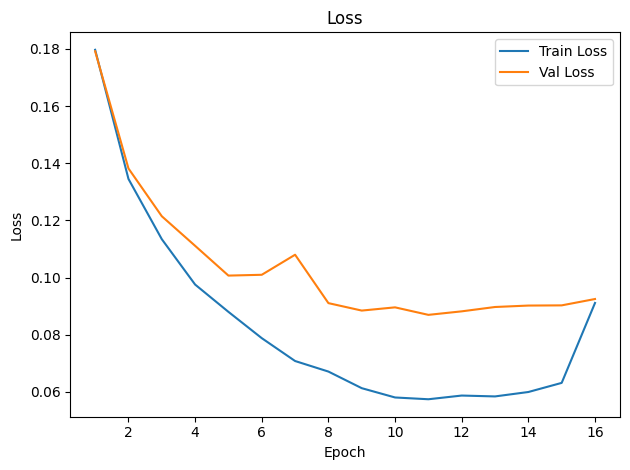

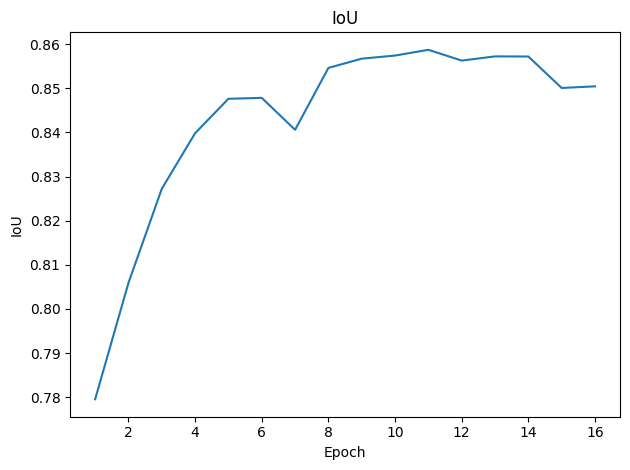

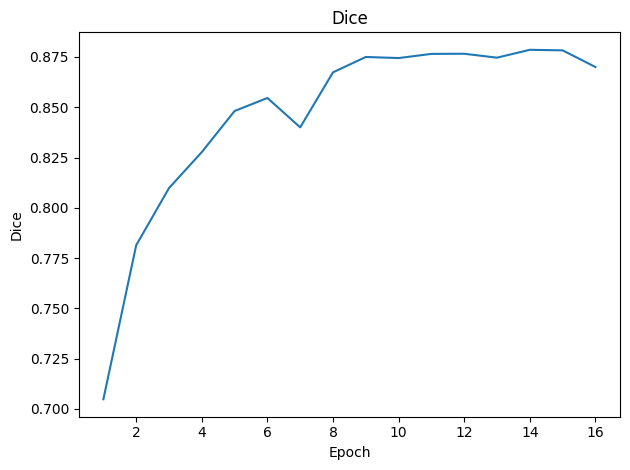

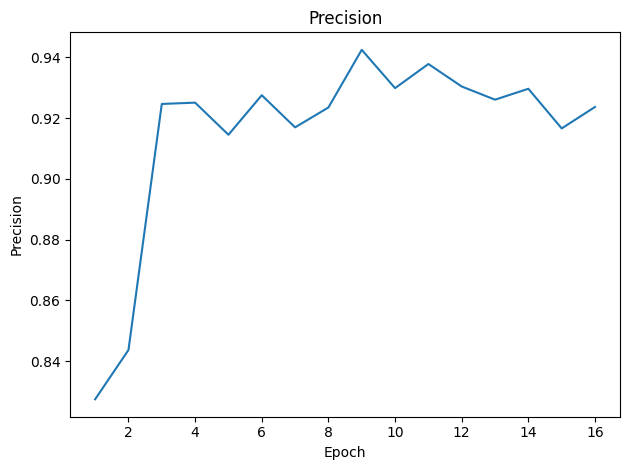

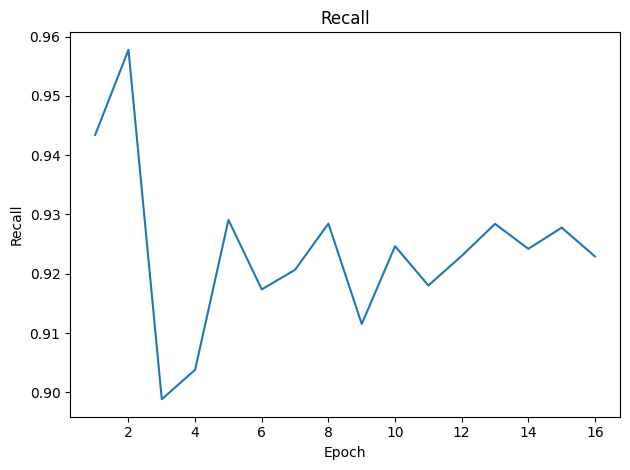

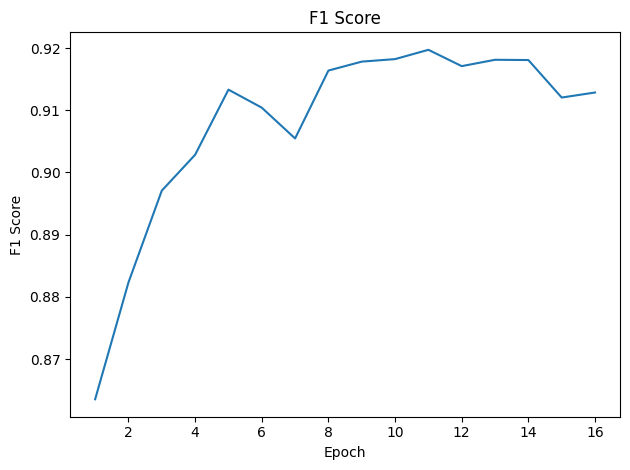

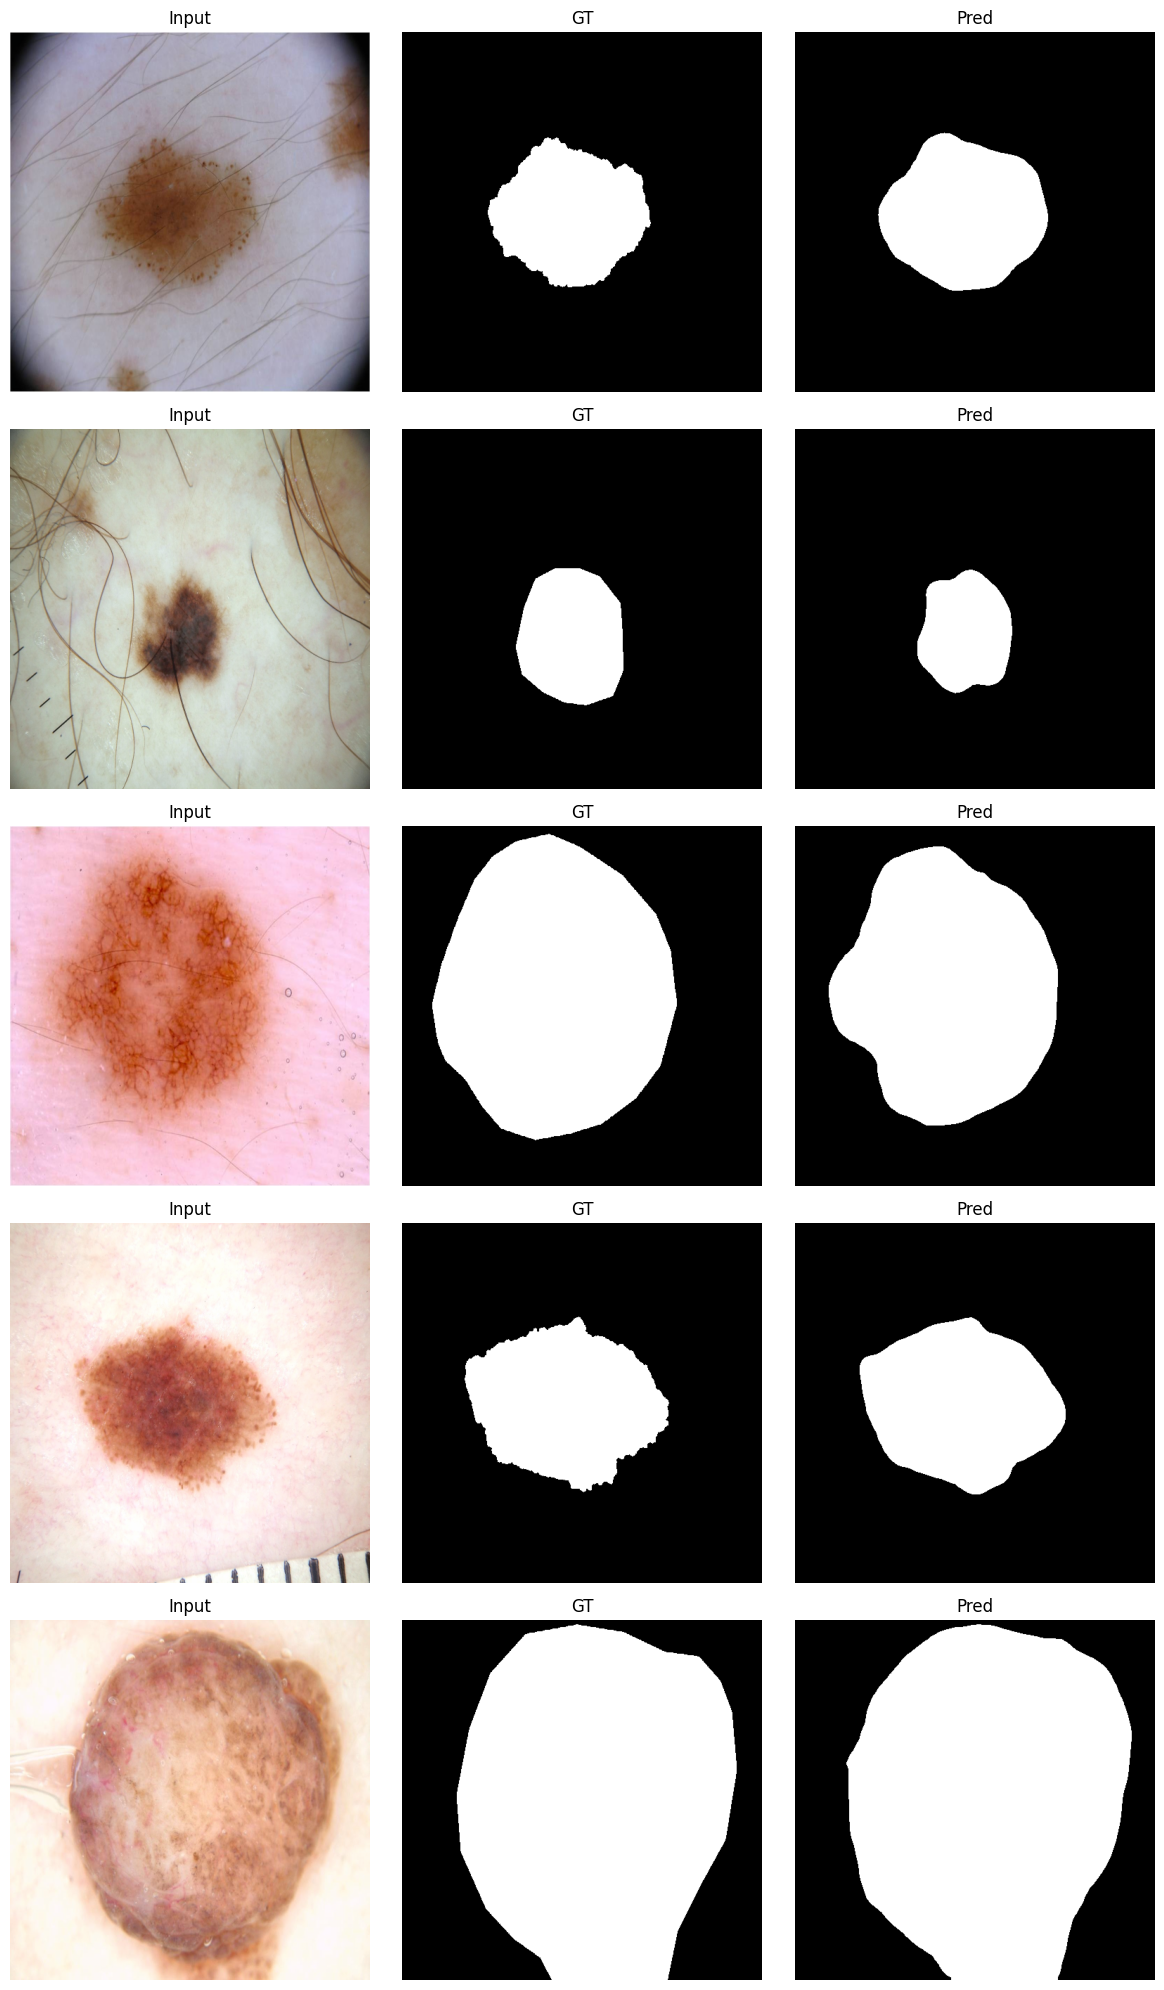

Hoàn tất.


In [ ]:

# -----------------------------
# 6. Vẽ biểu đồ kết quả
# -----------------------------
epochs = list(range(1, len(train_losses)+1))

plt.figure(); plt.plot(epochs, train_losses, label='Train Loss'); plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss'); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(); plt.plot(epochs, epoch_ious, label='IoU')
plt.xlabel('Epoch'); plt.ylabel('IoU'); plt.title('IoU'); plt.tight_layout(); plt.show()

plt.figure(); plt.plot(epochs, epoch_dices, label='Dice')
plt.xlabel('Epoch'); plt.ylabel('Dice'); plt.title('Dice'); plt.tight_layout(); plt.show()

plt.figure(); plt.plot(epochs, epoch_precs, label='Precision')
plt.xlabel('Epoch'); plt.ylabel('Precision'); plt.title('Precision'); plt.tight_layout(); plt.show()

plt.figure(); plt.plot(epochs, epoch_recs, label='Recall')
plt.xlabel('Epoch'); plt.ylabel('Recall'); plt.title('Recall'); plt.tight_layout(); plt.show()

plt.figure(); plt.plot(epochs, epoch_f1s, label='F1 Score')
plt.xlabel('Epoch'); plt.ylabel('F1 Score'); plt.title('F1 Score'); plt.tight_layout(); plt.show()

# -----------------------------
# 7. Hiển thị dự đoán mẫu
# -----------------------------
def denormalize(img, mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]):
    img = img.cpu().numpy().transpose(1,2,0)
    img = img * std + mean
    return np.clip(img,0,1)

def visualize_predictions(model, dataset, device, n=5):
    model.eval()
    idxs = random.sample(range(len(dataset)), n)
    fig, axs = plt.subplots(n,3, figsize=(12,4*n))
    with torch.no_grad():
        for i, idx in enumerate(idxs):
            img, mask = dataset[idx]
            out = torch.sigmoid(model(img.unsqueeze(0).to(device))['out'])[0,0].cpu().numpy()
            pred_mask = (out>0.5).astype(np.uint8)
            axs[i,0].imshow(denormalize(img)); axs[i,0].axis('off'); axs[i,0].set_title('Input')
            axs[i,1].imshow(mask[0].cpu(), cmap='gray'); axs[i,1].axis('off'); axs[i,1].set_title('GT')
            axs[i,2].imshow(pred_mask, cmap='gray'); axs[i,2].axis('off'); axs[i,2].set_title('Pred')
    plt.tight_layout(); plt.show()

visualize_predictions(model, val_ds, device, n=5)
print("Hoàn tất.")